## Objectives
- Train a model to classify cifar10 with very high accuracy as possible(above 85%)
- Tryout different models
  - large CNN
  - small CNN
  - small FC
  - large FC
  - without FC
  - with pooling
  - without pooling and with strides
- Try random weight performance principle on different models and choose the best model to train long
- add preprocessing like normalization, data augmentation(optional) and check performance
- visualize hidden filters

In [2]:
import sys
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt

In [3]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)

System Version: 3.13.0rc3 (main, Oct 30 2024, 17:56:08) [Clang 15.0.0 (clang-1500.3.9.4)]
PyTorch version 2.6.0
Torchvision version 0.21.0
Numpy version 2.2.4


In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [73]:
# define parameters
val_split = 0.1
batch_size = 64
num_trial_epochs = 10
num_final_epochs = 30
learning_rate = 0.001

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [64]:
# create train and validation split
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(val_split * num_train))

np.random.seed(3)
np.random.shuffle(indices)

train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

len(train_loader), len(val_loader)


(704, 79)

labels: ['cat', 'ship', 'ship', 'deer']
batch shape: torch.Size([64, 3, 32, 32])


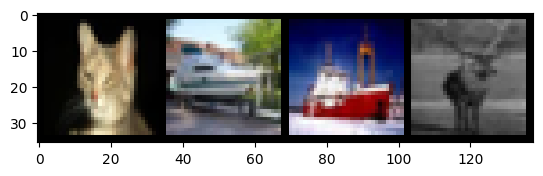

In [65]:
# show batch of images and all labels
dataiter = iter(train_loader)
sample_images, sample_labels = next(dataiter)

print(f"labels: {[classes[i] for i in sample_labels[:4]]}")
print(f"batch shape: {sample_images.size()}")

im = torchvision.utils.make_grid(sample_images[:4])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [8]:
# preprocess data if required and visualize a few

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [67]:
# Small model with large FC
class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ) # 16x16x16
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, 3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        ) # 8x8x8
        self.classifier = nn.Sequential(
            nn.Linear(8*8*8, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [85]:
model = SmallCNN()
model.to(device)
print(model)

SmallCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [69]:
# inference with untrained model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten().round(decimals=4) * 100


output: [10.39 10.69 10.38  9.04  9.76 10.14  9.94 10.29  9.88  9.51]
predicted label: car actual label: ship


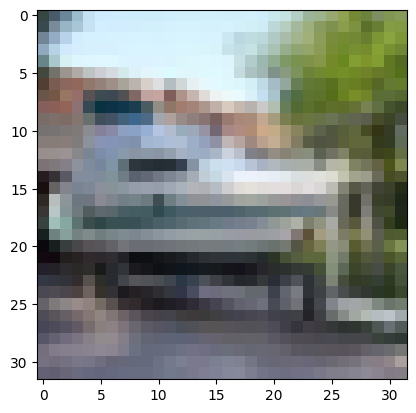

In [70]:
predictions = predict(model, sample_images[1].unsqueeze(0), device) # unsqueeze to send as batch
pred_label = predictions.argmax()
print(f"output: {predictions}")
print(f"predicted label: {classes[pred_label]} actual label: {classes[sample_labels[1]]}")
plt.imshow(np.transpose(sample_images[1].cpu().numpy(), (1, 2, 0)))

In [79]:
def train_loop(model, loss_fn, optimizer, num_epochs, train_loader, val_loader, device):
    train_size = len(train_loader)*batch_size
    val_size = len(val_loader)*batch_size
    train_loss_history, val_loss_history = [], []
    train_accuracy_history, val_accuracy_history = [], []

    for n in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0

        # train
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # predict
            output = model(images)
            loss = loss_fn(output, labels)

            # back propagate
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item() * labels.size(0)
            correct += (output.argmax(1) == labels).type(torch.float).sum().item()
        train_loss = running_loss / train_size
        train_accuracy = 100 * correct / train_size
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # validate
        model.eval()
        running_loss, correct = 0.0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # predict
                output = model(images)
                loss = loss_fn(output, labels)
                running_loss += loss.item() * labels.size(0)
                correct += (output.argmax(1) == labels).type(torch.float).sum().item()
        val_loss = running_loss / val_size
        val_accuracy = 100 * correct / val_size
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch: {n+1}/{num_epochs} - Train loss: {train_loss:>8f}, Train accuracy: {train_accuracy:>0.1f}%, Validation Loss: {val_loss:>8f}, Accuracy: {val_accuracy:>0.1f}%")
    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history


In [86]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [87]:
train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model, loss_fn, optimizer, num_trial_epochs, train_loader, val_loader, device)

Epoch: 1/10 - Train loss: 1.707675, Train accuracy: 37.9%, Validation Loss: 1.452463, Accuracy: 46.9%
Epoch: 2/10 - Train loss: 1.371873, Train accuracy: 50.2%, Validation Loss: 1.318538, Accuracy: 52.5%
Epoch: 3/10 - Train loss: 1.239960, Train accuracy: 55.6%, Validation Loss: 1.233144, Accuracy: 55.1%
Epoch: 4/10 - Train loss: 1.153487, Train accuracy: 58.8%, Validation Loss: 1.160606, Accuracy: 57.6%
Epoch: 5/10 - Train loss: 1.080796, Train accuracy: 61.5%, Validation Loss: 1.141860, Accuracy: 57.4%
Epoch: 6/10 - Train loss: 1.028561, Train accuracy: 63.4%, Validation Loss: 1.132833, Accuracy: 59.0%
Epoch: 7/10 - Train loss: 0.973107, Train accuracy: 65.4%, Validation Loss: 1.078811, Accuracy: 60.7%
Epoch: 8/10 - Train loss: 0.926729, Train accuracy: 67.1%, Validation Loss: 1.044574, Accuracy: 61.6%
Epoch: 9/10 - Train loss: 0.885395, Train accuracy: 68.6%, Validation Loss: 1.031951, Accuracy: 61.7%
Epoch: 10/10 - Train loss: 0.840745, Train accuracy: 70.1%, Validation Loss: 1.048

/var/folders/96/p1gk_hn90xqfg2360yj9t_qh0000gn/T/ipykernel_24547/3133728555.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


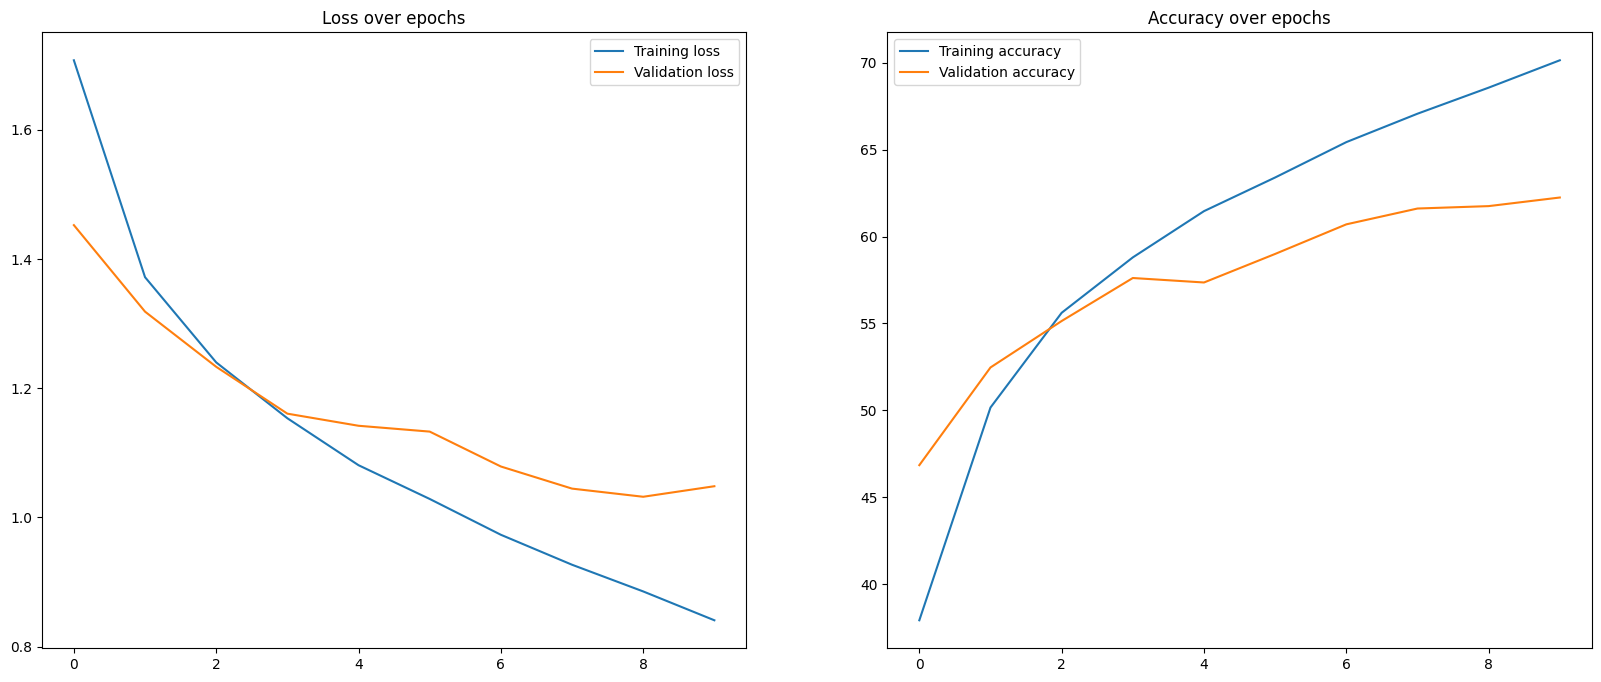

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Validation loss')
ax1.legend()
ax1.set_title("Loss over epochs")

ax2.plot(train_accuracies, label='Training accuracy')
ax2.plot(val_accuracies, label='Validation accuracy')
ax2.legend()
ax2.set_title("Accuracy over epochs")
fig.show()

In [ ]:
# test